# Information Retrieval - Corpus Filtering  
This notebook retrieves abstracts relevant to pandemics and then uses topic modeling to analyze the chosen abstracts.  Two info retrieval techniques are used: Literal Term Matching and Latent Semantic Indexing.  These are linear algebra techniques.  
We use the Scikit-Learn library.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS

/home/kjl5t/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# pull in data

# full corpus
df = pd.read_pickle("../../data/prd/Federal_RePORTER/FR-cleaned-2021FEB24.pkl")
#df = pd.read_pickle("/home/kjl5t/dspg21RnD/data/dspg21RnD/smaller-final-dataset.pkl")

# pandemics corpus
#df = pd.read_pickle("pandemic_corpus.pkl")
#df.reset_index(inplace = True)
#df.rename(columns={'index':'original index'}, inplace=True)

In [3]:
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,0,17608,152242,The multiprotein complex y-secretase proteolyt...,2008,1,1,The multiprotein complex y-secretase proteolyt...,T,1402,g,"[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y_secretase, proteolyt...","[multiprotein, y_secretase, proteolytically_cl...",Active Sites; Affect; Alzheimer's Disease; Am...,STRUCTURE OF SIGNAL PEPTIDE PEPTIDASE,HHS,NIH,NIA,5F32AG027647-03,12/1/2005,1/1/2008,"LIEBERMAN, RAQUEL L",NaN,07,030811269,BRIGHAM AND WOMEN'S HOSPITAL,BOSTON,MA,021156110,UNITED STATES,12/1/2007,1/1/2008,93.866,2008,3483.0,NaN
1,1,111864,190316,DESCRIPTION (provided by applicant): The Kis...,2008,1,1,The Kissl gene encodes peptides called kisspep...,T,2553,y,"[Kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...",Affect; Animal Model; Axon; Behavior; Behavio...,ROLE OF KISS1 NEURONS IN THE SEASONAL AND CIRC...,HHS,NIH,NICHD,5K99HD056157-02,9/1/2007,1/1/2009,"KAUFFMAN, ALEXANDER S",NaN,07,605799469,UNIVERSITY OF WASHINGTON,SEATTLE,WA,981959472,UNITED STATES,9/1/2008,1/1/2009,93.865,2008,39175.0,NaN
2,2,22052,154213,DESCRIPTION (provided by applicant): The objec...,2008,1,1,The objective of this research is to understan...,T,1414,e,"[objective, research, be, understand, biophysi...","[objective, research, be, understand, biophysi...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[biophysical, basis, thermodynamics_kinetic, m...",Agreement; Antibodies; base; Binding; Biochem...,CARBONIC ANHYDRASE AS A MODEL TO UNDERSTAND DI...,HHS,NIH,NIGMS,5F32GM076971-02,1/2/2007,1/1/2009,"MACK, ERIC T",NaN,05,082359691,HARVARD UNIVERSITY,CAMBRIDGE,MA,021385319,UNITED STATES,1/2/2008,1/1/2009,93.859,2008,49646.0,NaN
3,3,35004,159362,Obesity is the cause of many adverse pregnancy...,2008,1,1,Obesity is the cause of many adverse pregnancy...,O,1545,d,"[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, adverse, pregnancyoutcome, re...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, adverse_pregnancyoutcome, great, hea...",African; Analysis of Variance; Asians; Birth;...,OBESITY ON VAGAL TONE AND HBA1C DURING PREGNANCY,HHS,NIH,NINR,5F31NR009611-03,4/1/2006,1/1/2009,"HELMREICH, REBECCA J",NaN,09,800771594,UNIVERSITY OF TEXAS HLTH SCI CTR HOUSTON,HOUSTON,TX,770305400,UNITED STATES,4/1/2008,1/1/2009,93.361,2008,20406.0,NaN
4,4,371628,594482,Local potato advisory groups have expressed in...,2010,1,1,Local potato advisory groups have expressed in...,L,271,s,"[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, express, interest, m...",cost; Health; interest; Manure; Parasitic nem...,PLANT-PA

In [4]:
sum(df["PROJECT_START_DATE"].isna())

0

In [5]:
# input needed for doc-term matrix creation in Scikit-Learn is one string per document (not a list of strings).  
# Original data 'ABSTRACT' is already in this form, but not the tokens in "final_frqwds_removed"


tokens = df["stopwds_removed"]

docs = [] # docs will contain the processed tokens in string form (1 string per abstract)

for abstract in tokens:
    docs.append(" ".join(abstract))
    
docs = pd.Series(docs)


#docs = df["ABSTRACT"]  # raw text


### Term Matching

In [6]:
# new approach to grab all "pandemic" matches

term_match_idx = []

for i, abstract in enumerate(docs):
    if ('pandemic' in abstract): #or ('epidemic' in abstract):
        term_match_idx.append(i)
        

In [7]:
len(term_match_idx) 

2307

### Helper Functions

In [8]:
# Create binary query vector 

def create_query(words, terms):
    
    # words: search query words
    # terms: terms in corpus
    
    q = np.zeros(len(terms))  # number of terms

    idx = []
    for word in query_words:
        idx.append(terms.index(word))

    q[idx] = 1
    
    return q

In [9]:
def return_top_abstracts(scores, top_n):
    
    '''
    docs: Series that contains abstract
    scores: scores of abstracts
    top_n: return the top_n abstracts given by idx, if top_n = -1 return all abstracts
    '''
    # sort scores in descending order
    scores_sorted_idx = np.argsort(scores)[::-1]
    
    if top_n == -1:
        n = sum(scores > 0)
        ix = scores_sorted_idx[:n]
    else:
        ix = scores_sorted_idx[:top_n]
    
    #print(ix[0:10])
    
    return ix
    

In [10]:
def create_result_df(abstracts, scores):
    
    df = pd.DataFrame()
    df["abstracts"] = abstracts
    df["scores"] = scores
    
    return df

## Latent Semantic Indexing (LSI)

In [11]:
# Find doc-term matrix using TF-IDF weighting

tf_idf_vectorizer = TfidfVectorizer(min_df=20)
tf_idf = tf_idf_vectorizer.fit_transform(docs)

tf_idf_terms = tf_idf_vectorizer.get_feature_names()

In [12]:
len(tf_idf_terms)

73069

In [13]:
# CHANGE QUERY WORDS HERE

query_words = []

for word in tf_idf_terms:
    if 'pandemic' in word:
        query_words.append(word)

#query_words = ['pandemic', 'pandemics'] 
              
q = create_query(query_words, tf_idf_terms)

In [14]:
query_words

['pandemic', 'pandemics']

In [15]:
# Find the Truncated SVD of the TF-IDF matrix

lsa = TruncatedSVD(n_components=200, random_state=1)  # CHANGE THE NUMBER OF COMPONENTS - NOTE: MORE COMPONENTS 
                                                      # GIVES YOU A MORE ACCURATE APPROXIMATION OF THE DOC-TERM 
                                                      # MATRIX, BUT IS ALSO MORE EXPENSIVE AND MAY NOT LEAD TO THE 
                                                      # BEST INFO RETRIEVAL RESULTS.
USigma = lsa.fit_transform(tf_idf)
Vtrans = lsa.components_

In [16]:
S = lsa.singular_values_

In [17]:
S

array([131.42846235,  78.29545617,  59.26293043,  55.84475786,
        54.83924446,  50.97456289,  47.30147997,  44.1971259 ,
        41.68739349,  39.97459184,  39.56049829,  38.48671512,
        37.4524683 ,  36.17823385,  35.17781792,  34.93699223,
        34.01217915,  33.45551366,  33.04308953,  32.81267613,
        32.0278632 ,  31.9092402 ,  31.3118951 ,  31.18539203,
        30.69563793,  30.30047961,  30.18320173,  29.7931936 ,
        29.72104976,  29.60957144,  29.04418432,  28.62677431,
        28.14549119,  28.07848655,  27.70651087,  27.4544931 ,
        27.30376101,  27.210167  ,  27.11309153,  27.05092339,
        27.01906518,  26.72692633,  26.51392904,  26.41814337,
        26.34008856,  26.18801876,  26.04519203,  25.88175087,
        25.84763195,  25.79697347,  25.70938429,  25.5061714 ,
        25.38482374,  25.28334793,  25.02085471,  24.8806723 ,
        24.68355814,  24.46641436,  24.40113355,  24.37313529,
        24.27778064,  24.25327769,  24.04940599,  23.99

In [18]:
# transform query to be in same space as documents

q = q.reshape(1,-1)  # changes (n,) vector to (1,n)
qhat = lsa.transform(q)

In [19]:
print(qhat.shape)
print(USigma.shape)
print(Vtrans.shape)

(1, 200)
(690814, 200)
(200, 73069)


In [20]:
lsa_scores = cosine_similarity(qhat, USigma)  

In [21]:
sum(lsa_scores[0] > 0)

# 50: 375145
# 100: 379644
# 150: 372729
# 200: 362955
# 500: 354775

362955

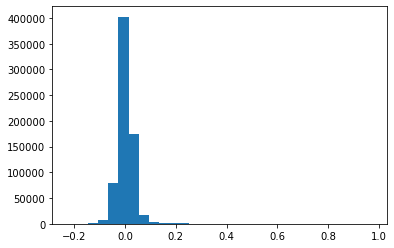

In [22]:
plt.hist(lsa_scores[0], bins = 30);
#plt.xlim(0.9, 1.1)

In [23]:
#np.percentile(lsa_scores[0], 93)

sum(lsa_scores[0] >= 0.5)#/len(lsa_scores[0])

# 50: 9731
# 100: 3520
# 150: 1505
# 200: 1447
# 500: 1307

1447

In [24]:
lsa_idx = return_top_abstracts(lsa_scores[0], 3000)  # CHANGE NUMBER OF TOP DOCS RETURNED
top_lsa_abstracts = docs[lsa_idx]

# top scores
lsa_scores[0][lsa_idx][0:10]

array([0.97306753, 0.96263049, 0.94909616, 0.94909616, 0.94006616,
       0.93754631, 0.93754631, 0.93754631, 0.93385689, 0.93147208])

In [25]:
top_lsa_abstracts[0:50]

656975    seasonality major effect spatiotemporal dynami...
532055    project fill fundamental knowledge gap influen...
506772    influenza major health threat world cause thou...
494325    influenza major health threat world cause thou...
62424     children ''s hospital corporation application ...
160659    provide rapid approach contain influenza threa...
141163    provide rapid approach contain influenza threa...
152028    provide rapid approach contain influenza threa...
634389    influenza remain important preventable cause m...
659636    influenza respiratory diseases southern hemisp...
575566    10 20 united state population suffer seasonal ...
477013    influenza major cause morbidity mortality near...
655408    recognize influenza pandemics 20th century his...
201626    goal project generate evidence inform non-phar...
658997    influenza respiratory diseases southern hemisp...
530525    influenza remain important cause morbidity mor...
658186    influenza major cause morbidit

#### Scratch work for choosing rank of Truncated SVD in LSI

Note: ending indices should each be +1 more than they are.

In [33]:
print(len(set(lsa_idx[0:2306]) - set(term_match_idx)))  # worst possible: 2307

# 50: 1772 .
# 100: 1622 .
# 150: 1462 .
# 200: 1344 .
# 500: 1342 .

len(set(term_match_idx).intersection(set(lsa_idx[:1446])))

1344


747

In [93]:
#idx_50 = lsa_idx
#idx_100 = lsa_idx
#idx_150 = lsa_idx
#idx_200 = lsa_idx
#idx_500 = lsa_idx

In [94]:
idx_50[0:50]

array([367176, 359975, 165083, 159197, 195614, 192354,  87187, 166197,
       184972, 180905, 374680, 190758, 374655, 476818, 171274, 568853,
       459330,  86152, 144080, 668292, 152978, 322361, 476180, 538655,
       532055,  84518, 182902, 667807, 157238, 191261, 180040, 183565,
       128226, 157053, 166876, 149957, 185250, 179546, 197965, 186328,
       193129, 190281, 268571, 144236, 669417, 684269,  42243,  42640,
       161305, 316242])

In [95]:
idx_100[0:50]

array([656975, 532055, 359975, 459330, 193129, 185250, 197965, 190281,
       179546, 186328, 367176, 161305,  86152, 374655,  62424, 142717,
       143762, 153784, 575566, 195614, 669417, 192354, 165083, 159197,
       183565, 414286, 682087, 374680, 190758, 188496, 322361, 538655,
       477013, 180905, 476818, 658186, 320839, 167280, 231632,  83536,
       541212, 165820,  16487, 157676, 541197, 530525, 424368, 152028,
       160659, 141163])

In [96]:
idx_150[0:50]

array([656975, 532055,  62424, 494325, 506772, 142717, 197965, 179546,
       185250, 193129, 186328, 190281, 575566, 477013, 161305, 682087,
       414286, 658186, 231632, 160659, 152028, 141163, 666335, 143762,
       530525, 153784, 634389, 655408, 659636, 532037, 201626, 280520,
       374655, 658791, 459330, 658997,  26944, 532890, 533383, 157676,
       655518, 174376, 367176, 386563, 359975, 536105, 169713, 188496,
       165820, 607701])

In [97]:
idx_200[0:50]

array([656975, 532055, 506772, 494325,  62424, 160659, 141163, 152028,
       634389, 659636, 575566, 477013, 655408, 201626, 658997, 530525,
       658186, 197965, 179546, 185250, 190281, 186328, 193129, 553218,
       142717, 585717, 308156,  26944, 231632, 666335, 682087, 414286,
        30019, 280520, 659738, 658791, 532037, 174376, 337268, 258900,
       256803,  91293, 257015, 217136, 532890, 533383, 459220, 477077,
       161305, 554107])

In [98]:
idx_500[0:50]

array([656975, 532055, 494325, 506772, 477013, 201626, 634389, 659636,
        26944, 658186, 655408, 530525, 575566, 585717, 658997, 553218,
        62424, 308156, 658791, 459220, 256803, 258900, 666335, 193129,
       197965, 190281, 179546, 186328, 185250, 659738, 519707, 406123,
       231632, 280520, 217136, 524203, 477077, 414286, 682087, 422364,
       257015,  91293, 657896, 142717, 337268, 143762, 153784,  30019,
       157676,  17508])

In [99]:
#pickle.dump([idx_50, idx_100, idx_150, idx_200, idx_500], open('rank_test.sav','wb'))

In [ ]:
# import saved data
f = open('rank_test.sav', 'rb')
[idx_50, idx_100, idx_150, idx_200, idx_500] = pickle.load(f)
f.close()

In [100]:
print(len(set(idx_50[0:999]) - set(idx_100[0:999]))) 

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_100[0:1999]))) 

318
--------
555


In [101]:
print(len(set(idx_50[0:999]) - set(idx_150[0:999])))
print(len(set(idx_100[0:999]) - set(idx_150[0:999])))

print('------------')

print(len(set(idx_50[0:1999]) - set(idx_150[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_150[0:1999])))

551
301
------------
956
530


In [102]:
print(len(set(idx_50[0:999]) - set(idx_200[0:999])))
print(len(set(idx_100[0:999]) - set(idx_200[0:999])))
print(len(set(idx_150[0:999]) - set(idx_200[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_200[0:1999])))

592
370
95
--------
1231
856
389


In [103]:
print(len(set(idx_50[0:999]) - set(idx_500[0:999])))
print(len(set(idx_100[0:999]) - set(idx_500[0:999])))
print(len(set(idx_150[0:999]) - set(idx_500[0:999])))
print(len(set(idx_200[0:999]) - set(idx_500[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_200[0:1999]) - set(idx_500[0:1999])))

611
399
133
55
--------
1259
888
433
85


In [28]:
lsa_scores[0][lsa_idx][1446]

0.500556382216268

In [120]:
# check overlap for the documents returned with cosine score > 0.5

#sum(lsa_scores[0] >= 0.5)

# 50: 9731
# 100: 3520
# 150: 1505
# 200: 1447
# 500: 1307

print(len(set(idx_150[0:1504]) - set(idx_200[0:1446])))
print(len(set(idx_150[0:1504]) - set(idx_500[0:1446])))
print(len(set(idx_200[0:1446]) - set(idx_500[0:1306])))

print('--------')

print(len(set(idx_150[0:1504]).intersection(set(idx_200[0:1446]))))
print(len(set(idx_150[0:1504]).intersection(set(idx_500[0:1306]))))
print(len(set(idx_500[0:1306]).intersection(set(idx_200[0:1446]))))

181
231
146
--------
1323
1216
1300


## Create filtered corpus

We use the results of our two information retrieval techniques to create a new, smaller corpus that only contains abstracts relevant to the query. 

In [26]:
docs_ix = np.concatenate([term_match_idx, lsa_idx[:1447]]) 

In [27]:
docs_idx = np.unique(docs_ix)

In [28]:
docs_idx.shape

(3006,)

**create case-study corpuses**

In [29]:
filt_corpus = df.loc[docs_idx, :]

In [30]:
filt_corpus.shape

(3006, 40)

In [31]:
filt_corpus.to_pickle("./pandemic_corpus.pkl")

#pandemic_corpus = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/pandemic_corpus.pkl")
#pandemic_corpus.shape

In [32]:
lim_docs = filt_corpus["final_frqwds_removed"]

In [33]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [34]:
len(lim_docs)

3006

## Topic Modeling with relevant pandemic abstracts

In [35]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [36]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP
nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True) #, max_features=int(len(lim_docs)/2))

nmf_tf_idf = nmf_vectorizer.fit_transform(text)

In [37]:
nmf_tf_idf.shape

(3006, 10368)

In [38]:
# topic modeling with NMF

nmf_model = NMF(n_components=10, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

In [39]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('antibody', 1.3890866496289127)
('ha', 0.9717156875420555)
('influenza', 0.944854267731217)
('epitope', 0.8652300089633391)
('virus', 0.6842244816428539)
('strain', 0.5125617153729217)
('conserve', 0.4751372984985678)
('immunogen', 0.44864935710374587)
('protective', 0.38490650924367986)
('cross', 0.36911760872798854)

Topic 1:
('hiv', 2.363269102713559)
('aids', 0.3757678320441777)
('infect', 0.21983826849966506)
('infection', 0.20980466459926717)
('transmission', 0.19544159407190118)
('env', 0.17387242615046253)
('prevention', 0.15338451578251602)
('woman', 0.1297704212327091)
('antiretroviral', 0.1263548021321297)
('individual', 0.12192585983060461)

Topic 2:
('vaccine', 1.7951093502244997)
('adjuvant', 0.35694770207499144)
('dna', 0.31382197667368633)
('dose', 0.3044157993544703)
('antigen', 0.25936244781655926)
('protection', 0.24756614105956695)
('efficacy', 0.24034805861418296)
('candidate', 0.22588594843395388)
('strain', 0.21874181496855508)
('immunogenicity', 0.214

In [44]:
# TRY TOPIC MODELING WITH LDA
# create document-term matrix

lda_vectorizer = CountVectorizer(max_df=1.0, min_df=3, lowercase=True)
lda_dtm = lda_vectorizer.fit_transform(text)

In [45]:
# create model

num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                      topic_word_prior=0.1, n_jobs=39, random_state = 0)
doc_top_dist = lda_model.fit_transform(lda_dtm)
top_term_dist = lda_model.components_

In [46]:
print_topics(lda_model, lda_vectorizer, 10)


Topic 0:
('virus', 1525.4434120604676)
('protein', 1126.1206467974187)
('viral', 1102.4826850278316)
('influenza', 1102.337619466158)
('drug', 959.4075573102688)
('cell', 862.1102503722885)
('host', 748.5477931671157)
('infection', 713.8863832057556)
('inhibitor', 686.472540751323)
('antiviral', 559.0138587330052)

Topic 1:
('influenza', 2516.301212913236)
('vaccine', 611.2175597088066)
('child', 517.3323659383097)
('vaccination', 493.1391539296775)
('respiratory', 346.13523581875955)
('health', 304.09035331927504)
('population', 298.6905077704604)
('virus', 284.0263811968307)
('illness', 283.11488938156197)
('age', 273.30372915922976)

Topic 2:
('health', 1355.3287110291553)
('hiv', 1056.795144906868)
('public', 712.8899074675587)
('clinical', 603.3312981168108)
('infectious', 533.0829880934559)
('need', 472.5800466109964)
('pandemic', 447.51365678286277)
('infection', 422.8808826831427)
('population', 420.70064017763826)
('technology', 418.9261234638962)

Topic 3:
('vaccine', 3723.7

In [55]:
filt_corpus.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
355,355,174965,583520,Since the 1960s Tennessee has been a leader in...,2008,1,1,Since the 1960s Tennessee has been a leader in...,S,3165,y,"[1960, Tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, adoption, conservati...",Active Learning; Adoption; Agriculture; AIDS/...,COLLABORATIVE RESEARCH WITH THE NATIONAL UNIVE...,USDA,NIFA,NaN,2008-51160-04373,5/15/2008,1/14/2009,"WALKER, FORBES R","EASH, NEAL",02,133891015,UNIVERSITY OF TENNESSEE,KNOXVILLE,TN,37996-4540,UNITED STATES,NaN,NaN,10.212,2008,95987.0,NaN
759,759,1001252,1101260,Rapidly spreading Zika virus (ZIKV) is an emer...,2017,1,1,Rapidly spreading Zika virus (ZIKV) is an emer...,R,3561,y,"[rapidly, spread, Zika, virus, ZIKV, emerge, z...","[rapidly, spread, zika, virus, zikv, emerge, z...","[rapidly, spread, zika, virus, zikv, emerge, z...","[rapidly, spread, zika_virus_zikv, emerge, zoo...","[rapidly, spread, zika_virus_zikv, emerge, zoo...","[rapidly, spread, zika_virus_zikv, emerge, zoo...",Adult; Aedes; Africa; Americas; Antibodies; A...,NEW LIVE ATTENUATED ZIKA VIRUS VACCINE,DOD,CDMRP,NaN,PR172269,7/15/2018,1/14/2020,"ZENG, MINGTAO",NaN,19,609980727,TEXAS TECH UNIVERSITY HEALTH SCIENCES CENTER,EL PASO,TX,79905,UNITED STATES,NaN,NaN,12.420,2017,305997.0,NaN
767,767,1001101,1101109,Topic Area: InfluenzaArea of Emphasis: Develop...,2017,1,1,Topic Area: InfluenzaArea of Emphasis: Develop...,T,4219,y,"[topic, area, InfluenzaArea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, influenzaarea, emphasis, evaluation, i...",Adaptive Immune System; Address; Adjuvant; ae...,"APPLICATION OF AN IMMUNE-MODULATING, ANTI-INFL...",DOD,CDMRP,NaN,PR170327,7/15/2018,1/14/2020,"SIEGEL, HAL",NaN,06,080294428,NEW AMSTERDAM SCIENCES,SCOTTSDALE,AZ,85260,UNITED STATES,NaN,NaN,12.420,2017,204046.0,NaN
1873,1873,441317,813151,Objective(s): The safety of aquaculture produc...,2011,1,1,"The safety of aquaculture products, particular...",T,4679,s,"[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...",Affect; Algae; Aquaculture; Bacteriophages; B...,PATHOGEN DETECTION AND INTERVENTION METHODS FO...,USDA,ARS,NaN,ARS-0420935,1/31/2011,1/30/2016,"RICHARDS, GARY P",NaN,13,NaN,AGRICULTURAL RESEARCH SERVICE,WYNDMOOR,PA,19038,UNITED STATES,NaN,NaN,10.001,2011,865694.0,NaN
1949,1949,165262,270537,This subproject is one of many research subpro...,2008,1,1,Synthesis of a new type of potential influenza...,S,92,d,"[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, influenza, inhibitor, alter, immun...",Computer Retrieval of Information on Scientif...,"INFLUENZA INHIBITORS, 8 C